# Pairs-Trading (Beta Neutral) Strategy Analysis

The beta neutral trading strategy is a market-neutral approach designed to eliminate systematic market risk by constructing a portfolio that has a net beta of zero. This strategy aims to generate alpha (excess returns above the market) by taking both long and short positions in securities such that the overall portfolio is insulated from broad market movements.

Key Concepts:
- **Beta**: A measure of a security's volatility in relation to the overall market. A beta of 1 indicates that the security moves with the market, a beta greater than 1 indicates higher volatility than the market, and a beta less than 1 indicates lower volatility.
- **Market Neutral**: A strategy that seeks to minimize exposure to market risk, focusing on generating returns from the individual performance of securities rather than market movements.

Here's how it works:

- **Identifying a Pair / Basket of Tokens**: Identify a set of tokens with varying betas.
- **Calculating Beta**: Use historical price data to calculate the beta of each token relative to a benchmark token (e.g., BTC and ETH). This can be done using regression analysis where the token's returns are regressed against the benchmark's returns.
- **Constructing the Portfolio**: 
    - **Long Positions**: Select tokens with positive alpha (expected to outperform their beta-implied returns) and go long on these.
    - **Short Positions**: Select tokens with negative alpha (expected to underperform their beta-implied returns) and short these.
    - Ensure the weighted average beta of the long positions is equal to the weighted average beta of the short positions, resulting in a net beta of zero.
- **Position Sizing**: Calculate the dollar amount for each position to ensure that the portfolio remains beta neutral. This involves balancing the dollar value of long and short positions based on their respective betas.
- **Monitoring and Rebalancing**: Regularly monitor the portfolio to ensure it remains beta neutral. Adjust positions as necessary to maintain the desired beta neutrality, especially if there are significant changes in the market or individual tokens.

In this notebook, the pair trading negative / low correlation strategy is demonstrated using cryptocurrency price data sourced from the Binance, OKX, and Bybit APIs.

## Credits

This notebook heavily references [quant_playground](https://github.com/rukawa917/quant_playground) repository by [rukawa917](https://github.com/rukawa917) and [mkt_neutral.ipynb](https://gist.github.com/FilippoGuerrieri26/8086c42db442835234dd61ea6c07decb) by [FilippoGuerrieri26](https://gist.github.com/FilippoGuerrieri26). I want to extend my sincere gratitude to them for creating this valuable resource.


## Prepare your Environment

Ensure that the 'venv' kernel is selected for this notebook. If not, click on 'Kernel' at the top bar, select 'Change Kernel...' and select 'venv' as the kernel. For convenience, ensure that 'Always start the preferred kernel' is ticked. Click 'Select' to confirm the setting.

Install the environment's dependencies using the command below. After installation, restart the kernel to use the updated packages. To restart, click on 'Kernel' at the top bar and select 'Restart Kernel' and click on 'Restart'. Please skip this step if you have already done it.

In [ ]:
pip install -r requirements.txt

## Import packages

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import sys
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import coint
from itertools import combinations
from statsmodels.tsa.stattools import coint
from utils import calculate_profit, plot_strategy
from data_manager import load_ts_df, process_data, sanitize_data
from typing import List
import cvxpy as cvx
import warnings

pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")

## Process Price Dataframe

- Before proceeding, ensure that the price data has been downloaded using ***'data_manager.py'***.
- Enter the ***cex*** (Centralized Exchange) and ***interval*** values used for data download to load the relevant *.pkl* files and retrieve the dataframe.
- You can specify a batch of pairs to load using the ***selected_pairs*** variable. If no pairs are selected, all available pairs will be loaded by default.
- Note that some pairs might be new and may lack sufficient data within the downloaded timeframe. Such pairs will be removed based on the ***nan_remove_threshold*** setting, which defines the maximum percentage of NaN values allowed relative to the total data points. For example, with a ***nan_remove_threshold*** of 0.1, if a pair has 100 data points and 15 are NaN, the pair will be excluded.
- From the remaining pairs, you can filter the top N volume pairs using the ***top_n_volume_pairs*** parameter.
- This part of the code will also ensure that all timeseries columns have the same number of data points.
- The earliest and latest dates for all pairs will be recorded. These dates can then be used to determine the timeframe for slicing the data in the next step.

### Inputs

In [2]:
##### INPUTS #####
cex = 'binance'
interval = '4h'
nan_remove_threshold = 0.0

# Select only the pairs below to analyse. The key represents the pair and its value represents the direction it must take. 
# 1: Long, -1: Short, 0: Does not matter
# Unlike other notebooks, no pairs will be selected if the dictionary is empty. 
# selected_pairs = {'SOLUSDT':1, 'OMNIUSDT':-1, 'XAIUSDT':-1, 'STRKUSDT':-1, 'TNSRUSDT':-1, 'PORTALUSDT':-1, 
#                   'WUSDT':-1, 'ALTUSDT':-1, 'BTCUSDT':0}
selected_pairs = {'ALTUSDT': -1, 'SOLUSDT': 1, 'TRXUSDT': 0, 'BTCUSDT':0}

# Select only the top N mean volume pairs from the selected pairs to analyse.
top_n_volume_pairs = 100

# Select volume filter mode. Options: ['rolling', 'mean'].
volume_filter_mode = 'rolling'

# Split train and test data. If False, all data will be used as train and test.
train_test_split = False

# Only applies if train_test_split = True
train_percentage = 0.5 # only from 0 < train_percentage <= 1

# Minimum Long and Minimum Short. If min_long == 0.1, the weight for any pair selected for a long position will be optimized to at 
# least 0.1 after normalization, though this is not guaranteed. Similarly, if min_short == 0.1, the weight for any pair selected 
# for a short position will aim to be at least 0.1 after normalization, but this may not always be achievable.
min_long = 0.1
min_short = 0.1

# Rolling optimisation unsolvable count threshold before exit. If total number of datetime is 1000 and unsolvable_threshold == 0.05, 
# then the max_unsolvable_count = 1000 * 0.05 = 50. If there are 50 consecutive unsolvable optimisation, the rolling optimisation
# will stop.
unsolvable_threshold = 0.05
##################

In [3]:
print("\nMode: Pairs-Trading (Beta Neutral) Strategy")
print("CEX: {}".format(str(cex).capitalize()))
print("Interval: {}".format(interval))
print("NaN Remove Threshold: {}".format(nan_remove_threshold))
print("Selected pairs to analyse: {}".format(list(selected_pairs.keys())))
print("Top N Volume Pairs: {}".format(top_n_volume_pairs))
print("Volume Filter Mode: {}".format(str(volume_filter_mode).capitalize()))

merged_df = process_data('beta_neutral', cex, interval, nan_remove_threshold, selected_pairs,
                 top_n_volume_pairs, volume_filter_mode)

print("\n")


Mode: Pairs-Trading (Beta Neutral) Strategy
CEX: Binance
Interval: 4h
NaN Remove Threshold: 0.0
Selected pairs to analyse: ['ALTUSDT', 'SOLUSDT', 'TRXUSDT', 'BTCUSDT']
Top N Volume Pairs: 100
Volume Filter Mode: Rolling
Successfully loaded candlestick dataframe for all available pairs.

Earliest time series start date: 2024-02-18
Latest time series end date: 2024-08-03




## Sanitize the dataframe

- Slice the dataframe according to the specified ***start_date*** and ***end_date***. Choose ***start_date*** and ***end_date*** within the timeframe shown by the output of the previous cell.
- Interpolate any missing values in the dataframe.
- If the interpolation fails, just backfill with the latest valid value.
- Verify that all is as expected with an `assert` and check the shapes of 2 random pairs, which should have the same dimensions.

### Inputs

In [4]:
##### INPUTS #####
start_date = '2024-02-18' # refer to the previous output to set
end_date = '2024-08-03' # refer to the previous output to set
##################

In [5]:
print("\n")

data_sanitized, sorted_available_pairs = sanitize_data(merged_df, start_date, end_date)

if data_sanitized:
    print("-Data Check-")
    keys = list(data_sanitized.keys())
    count = 0

    for key in keys:
        print("{}'s Data Shape: {}".format(key, data_sanitized[key].shape))
        count+=1

        if count == 2:
            break
            
else:
    print("No data found.")

print("\n")



-Data Check-
BTCUSDT's Data Shape: (999, 1)
SOLUSDT's Data Shape: (999, 1)




## Compute Percentage Returns

To compute percentage returns with a time series of close data, you first need to calculate the daily returns by finding the percentage change between consecutive prices. This can be done using the formula below:
$$Percentage \space Return = \frac{Price_{t} - Price_{t-1}}{Price_{t-1}} \times 100$$
1. ${Price_{t}}$ is the calculated price on day t.
2. ${Price_{t-1}}$ is the calculated price on the previous candlestick.

In a pandas DataFrame, this can be efficiently computed using the pct_change() method on the price column. The resulting series represents the daily percentage returns, reflecting the day-to-day performance of the asset. Summarizing or compounding these daily returns over longer periods can provide insights into the overall performance of the asset over time.

In [6]:
print("\n")

returns = pd.DataFrame()

for pair, df in data_sanitized.items():
    tmp_return_df = df['Close'].pct_change().dropna().to_frame(name=pair)
    returns = pd.merge(returns, tmp_return_df, how='outer', left_index=True, right_index=True)
returns = returns.T.sort_index().T

print("-Data Check-")
print("Percentage Returns' Data Shape (should be 1 row lesser than printed above): {}".format(returns.shape))
print("\n")




-Data Check-
Percentage Returns' Data Shape (should be 1 row lesser than printed above): (998, 4)




## Split Train and Test Dataset

This is for backtesting later.

In [7]:
print("\n")

if train_test_split:
    total_length = len(returns)
    train_length = int(total_length * train_percentage)
    test_length = total_length - train_length

    if train_length != 0 and test_length != 0:
        train_return_df = returns.reset_index().loc[:total_length-test_length].iloc[:-1].set_index('Open Time')
        test_return_df = returns.reset_index().loc[total_length-test_length:].set_index('Open Time')
        full_return_df = pd.concat([train_return_df, test_return_df])

        print("-Data Check-")
        print("Train Returns' Data Shape: {}".format(train_return_df.shape))
        print("Test Returns' Data Shape: {}".format(test_return_df.shape))

    else:
        print("Train and test length must be more than 0.")
        
else:
    train_return_df = returns.reset_index().loc[:].iloc[:-1].set_index('Open Time')
    test_return_df = train_return_df.copy()
    full_return_df = train_return_df.copy()

    print("-Data Check-")
    print("Train Returns' Data Shape: {}".format(train_return_df.shape))
    print("Test Returns' Data Shape: {}".format(test_return_df.shape))

print("\n")



-Data Check-
Train Returns' Data Shape: (997, 4)
Test Returns' Data Shape: (997, 4)




## Market Neutral Optimization

In order to be able to compute market neutral weights, we need the VCV matrix of the constituents and the betas to market.
Recall that portfolio beta is equal to the sum of the (weighted) beta of the constituents

In [8]:
Sigma = train_return_df.cov()
Sigma.head()

,ALTUSDT,BTCUSDT,SOLUSDT,TRXUSDT
ALTUSDT,0.000360,0.000081,0.000143,0.000036
BTCUSDT,0.000081,0.000063,0.000080,0.000020
SOLUSDT,0.000143,0.000080,0.000186,0.000032
TRXUSDT,0.000036,0.000020,0.000032,0.000025


## Select Pairs for Detailed Analysis

- Please select any pair combination from the output below.

In [9]:
print("\nSelectable pairs:")

for pair in sorted_available_pairs:
    print("- {}".format(pair))

sorted_available_pairs = {pair:selected_pairs[pair] for pair in sorted_available_pairs if pair in selected_pairs}

print("\n")


Selectable pairs:
- ALTUSDT
- BTCUSDT
- SOLUSDT
- TRXUSDT




## Inputs

In [10]:
##### INPUTS #####
benchmark_token = 'BTCUSDT'
##################

In [11]:
print("\n")

betas = Sigma[benchmark_token] / Sigma.loc[benchmark_token, benchmark_token]
betas.drop(benchmark_token, inplace=True)
betas = betas.sort_values(ascending=False)

print("-Data Check-")
print("Betas:")
print(betas)

betas = betas.sort_index()

print("\n")



-Data Check-
Betas:
ALTUSDT    1.289039
SOLUSDT    1.267353
TRXUSDT    0.319203
Name: BTCUSDT, dtype: float64




In [12]:
train_return_df.drop(benchmark_token, axis=1, inplace=True)  # since we are using BTC as the benchmark
final_Sigma = train_return_df.cov()

## CVXPY Optimization Function

We are going to setup a minimization problem.
We want to minimize the portofolio variance like in a simple MV framework, but subject to an additional constrain:
The sum of the constituents (weighted) betas must add up to 0, in order to achieve market neutrality

In [13]:
def dynamic_scaling(ratio, base_factor = 1.25):
    return ratio * base_factor
    

def optimize_beta_neutral_portfolio(cov_matrix, mkt_betas, sorted_available_pairs, min_long=0.1, min_short=-0.1, tolerance=1e-4) -> pd.DataFrame:
    index_direction_dict = {mkt_betas.index.get_loc(pair):sorted_available_pairs[pair] for pair in mkt_betas.index if pair in sorted_available_pairs}
    index_min_long_short_dict = {}
    for pair in mkt_betas.index:
        if pair in sorted_available_pairs:
            if sorted_available_pairs[pair] == 1:
                index_min_long_short_dict[mkt_betas.index.get_loc(pair)] = abs(min_long)
            elif sorted_available_pairs[pair] == -1:
                index_min_long_short_dict[mkt_betas.index.get_loc(pair)] = -1 * abs(min_short)

    try_count = 1
    finish_flag = False

    while try_count <= 10 and finish_flag == False:

        finish_flag = True

        n = cov_matrix.shape[1]
        weights = cvx.Variable(n)
        pf_var = cvx.quad_form(weights, cov_matrix.values)
        objective = cvx.Minimize(pf_var)

        constraints = [
            # weights.T @ mkt_betas == 0,
            # cvx.sum(weights) == 1,
            cvx.abs(weights.T @ mkt_betas) <= tolerance,  # Allow a small deviation from zero
            cvx.abs(cvx.sum(weights) - 1) <= tolerance  # Allow a small deviation from 1
        ]
        
        for i, d in index_direction_dict.items():
            if d == 1:
                constraints.append(weights[i] >= index_min_long_short_dict[i])
            elif d == -1:
                constraints.append(weights[i] <= index_min_long_short_dict[i])
    
        prob = cvx.Problem(objective, constraints)
        if not prob.is_dcp():
            raise Exception("Problem is not DCP")
    
        prob.solve()
        if prob.status != cvx.OPTIMAL:
            raise Exception("Optimization problem is not solvable")
    
        weights = weights.value
    
        sum_weights = np.sum(np.abs(weights))
        weights = weights / sum_weights

        # print(index_direction_dict)
        # print(index_min_long_short_dict)
        # print(weights)
    
        for i, ls in index_min_long_short_dict.items():
            if index_min_long_short_dict[i] >= 0:
                if min_long > weights[i]:
                    ratio = min_long / weights[i]
                    scale_factor = dynamic_scaling(ratio)
                    # print(min_long, weights[i], scale_factor)
                    index_min_long_short_dict[i] *= scale_factor
                    finish_flag = False
            else:
                if abs(min_short) > abs(weights[i]):
                    ratio = abs(min_short) / abs(weights[i])
                    scale_factor = dynamic_scaling(ratio)
                    # print(-1 * abs(min_short), weights[i], scale_factor)
                    index_min_long_short_dict[i] *= scale_factor
                    finish_flag = False

        # print("\n")
        
        try_count += 1

    w = pd.Series(weights, index=cov_matrix.columns)

    return w

w = optimize_beta_neutral_portfolio(final_Sigma, betas, sorted_available_pairs, min_long, min_short)


## Plot Portfolio Weights

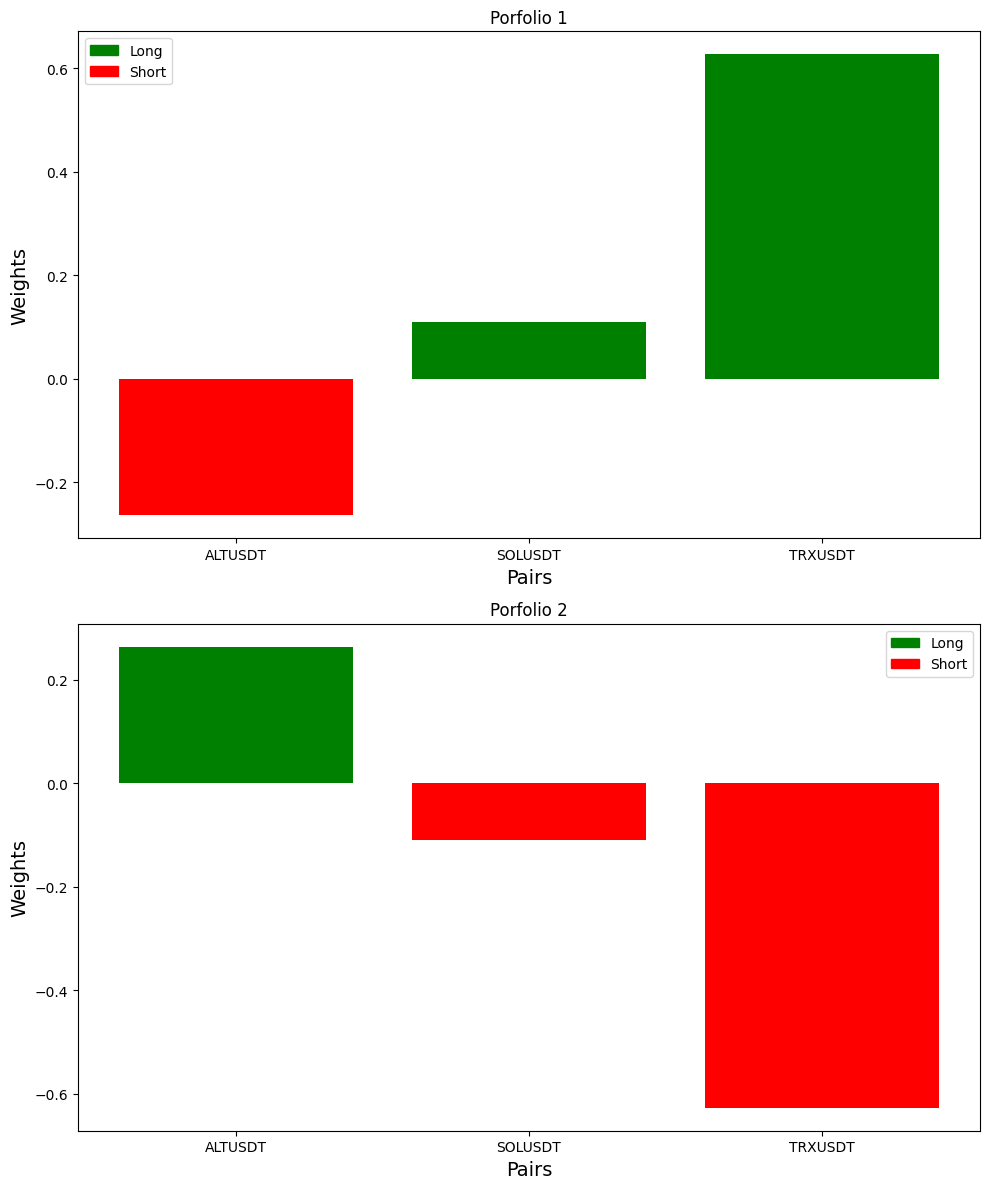

In [14]:
index = list(w.index)
values = list(w.values)

plt.figure(figsize=(10, 12))

long_patch = mpatches.Patch(color='green', label='Long')
short_patch = mpatches.Patch(color='red', label='Short')

plt.subplot(2, 1, 1)
colors = ['green' if val >= 0 else 'red' for val in values]
plt.bar(w.index, w.values, color=colors)
plt.title('Porfolio 1')
plt.xlabel('Pairs', fontsize=14)
plt.ylabel('Weights', fontsize=14)
plt.legend(handles=[long_patch, short_patch])

plt.subplot(2, 1, 2)
colors = ['green' if val < 0 else 'red' for val in values]
plt.bar(w.index, -w.values, color=colors)
plt.title('Porfolio 2')
plt.xlabel('Pairs', fontsize=14)
plt.ylabel('Weights', fontsize=14)
plt.legend(handles=[long_patch, short_patch])

plt.tight_layout()
plt.show()

In [15]:
print("\n")

weights_df_solution_one = pd.DataFrame(w, columns=['Weights'], index=w.index)
weights_df_solution_two = weights_df_solution_one.copy()
weights_df_solution_two['Weights'] = -weights_df_solution_two['Weights']

weights_df_solution_one = weights_df_solution_one.sort_values(by='Weights', ascending=False)
weights_df_solution_two = weights_df_solution_two.sort_values(by='Weights', ascending=False)

weights_df_solution_one['Direction'] = weights_df_solution_one['Weights'].apply(lambda x: 'Long' if x > 0 else 'Short')
weights_df_solution_two['Direction'] = weights_df_solution_two['Weights'].apply(lambda x: 'Long' if x > 0 else 'Short')

print("Portfolio 1:")
print(weights_df_solution_one)
print("\n")
print("Portfolio 2:")
print(weights_df_solution_two)

print("\n")



Portfolio 1:
          Weights Direction
TRXUSDT  0.627090      Long
SOLUSDT  0.109754      Long
ALTUSDT -0.263156     Short


Portfolio 2:
          Weights Direction
ALTUSDT  0.263156      Long
SOLUSDT -0.109754     Short
TRXUSDT -0.627090     Short




In [16]:
print("\n")

total_weight = weights_df_solution_one['Weights'].abs().sum()
print("Sum of Weights:", total_weight)

print("\n")



Sum of Weights: 0.9999999999999999




## Rolling Portfolio Beta

In [17]:
# rolling covariance matrix starting from the test data
rolling_cov = full_return_df.rolling(window=10).cov().dropna()
rolling_cov.head()

ALTUSDT   BTCUSDT   SOLUSDT   TRXUSDT
Open Time                                                          
2024-02-20 08:00:00 ALTUSDT  0.000477  0.000022  0.000042  0.000014
                    BTCUSDT  0.000022  0.000014  0.000012  0.000004
                    SOLUSDT  0.000042  0.000012  0.000038  0.000007
                    TRXUSDT  0.000014  0.000004  0.000007  0.000006
2024-02-20 12:00:00 ALTUSDT  0.000517  0.000023  0.000017  0.000012

In [18]:
# Rolling optimization
dates = list(set(rolling_cov.index.get_level_values(0)))
dates.sort()
weights = pd.DataFrame(index=pd.Index(dates).sort_values(), columns = test_return_df.columns)
betas = pd.DataFrame(index=pd.Index(dates).sort_values(), columns = test_return_df.columns)

total_no_dates = len(dates)
max_unsolvable_count = int(total_no_dates * unsolvable_threshold)
unsolvable_count = 1

for i, dt in enumerate(dates):
    full_cov = rolling_cov.loc[dt]
    final_cov = full_cov.drop(benchmark_token).drop(benchmark_token, axis=1)
    final_beta = full_cov[benchmark_token].drop(benchmark_token) / full_cov.loc[benchmark_token, benchmark_token]

    try:
        weight_result = optimize_beta_neutral_portfolio(final_cov, final_beta, sorted_available_pairs, min_long, min_short)
        unsolvable_count = 1
    except:
        if unsolvable_count >= max_unsolvable_count:
            print("\n")
            print("Rolling optimization is not solvable. Please debug the issue first before proceeding.")
            print("\n")
            break
        
        if i != 0:
            weight_result = weights.iloc[i - 1].drop(benchmark_token)
        else:
            weight_result = pd.Series(0.0, index=final_cov.columns)

        unsolvable_count += 1
        
    weights.loc[dt, :] = weight_result
    betas.loc[dt, :] = final_beta

In [19]:
weights.drop(benchmark_token, axis=1, inplace=True)
betas.drop(benchmark_token, axis=1, inplace=True)

weights_df_solution_one = weights.copy()
weights_df_solution_two = weights.copy()
weights_df_solution_two = weights_df_solution_two * -1

In [20]:
print("\n")

print("-Data Check-")
print("Rolling Betas:")
print(betas.head())
print(betas.tail())
# print(betas)

print("\n")



-Data Check-
Rolling Betas:
                      ALTUSDT   SOLUSDT   TRXUSDT
2024-02-20 08:00:00   1.55274  0.863711  0.283387
2024-02-20 12:00:00  1.744198  0.997297  0.327125
2024-02-20 16:00:00  2.629238  1.232706  0.326865
2024-02-20 20:00:00  3.004905  1.357912  0.426292
2024-02-21 00:00:00  2.850504  1.240768  0.495531
                      ALTUSDT   SOLUSDT   TRXUSDT
2024-08-02 04:00:00  0.827324  1.238518  0.258546
2024-08-02 08:00:00  0.856581  1.256829  0.221842
2024-08-02 12:00:00   0.93381  1.254396  0.303432
2024-08-02 16:00:00  1.365124  1.420334  0.401318
2024-08-02 20:00:00  1.297125  1.260893  0.284909




In [21]:
print("\n")

print("-Data Check-")
print("Porfolio 1 Rolling Weights:")
print(weights_df_solution_one.head())
print(weights_df_solution_one.tail())
# print(weights_df_solution_one)
print("\n")
print("Porfolio 2 Rolling Weights:")
print(weights_df_solution_two.head())
print(weights_df_solution_two.tail())
# print(weights_df_solution_two)

print("\n")



-Data Check-
Porfolio 1 Rolling Weights:
                      ALTUSDT   SOLUSDT   TRXUSDT
2024-02-20 08:00:00  -0.19176  0.118503  0.689738
2024-02-20 12:00:00 -0.196148   0.11821  0.685643
2024-02-20 16:00:00 -0.147358  0.120123  0.732519
2024-02-20 20:00:00 -0.156891   0.12033  0.722778
2024-02-21 00:00:00 -0.174936  0.120603  0.704461
                      ALTUSDT   SOLUSDT   TRXUSDT
2024-08-02 04:00:00 -0.341221  0.114297  0.544482
2024-08-02 08:00:00 -0.301909  0.100275  0.597815
2024-08-02 12:00:00 -0.322461  0.100493  0.577047
2024-08-02 16:00:00 -0.289283  0.107679  0.603038
2024-08-02 20:00:00 -0.248229  0.110502  0.641268


Porfolio 2 Rolling Weights:
                      ALTUSDT   SOLUSDT   TRXUSDT
2024-02-20 08:00:00   0.19176 -0.118503 -0.689738
2024-02-20 12:00:00  0.196148  -0.11821 -0.685643
2024-02-20 16:00:00  0.147358 -0.120123 -0.732519
2024-02-20 20:00:00  0.156891  -0.12033 -0.722778
2024-02-21 00:00:00  0.174936 -0.120603 -0.704461
                      ALTUS

In [22]:
print("\n")

print("-Data Check-")
print("Porfolio 1 Beta:")
portfolio_one_beta = (weights_df_solution_one.shift(1) * betas).dropna().sum(axis=1)
print(portfolio_one_beta.head())
print(portfolio_one_beta.tail())
# print(portfolio_one_beta)
print("\n")
print("Portfolio 2 Beta")
portfolio_two_beta = (weights_df_solution_two.shift(1) * betas).dropna().sum(axis=1)
print(portfolio_two_beta.head())
print(portfolio_two_beta.tail())
# print(portfolio_two_beta)

print("\n")



-Data Check-
Porfolio 1 Beta:
2024-02-20 12:00:00    0.009346
2024-02-20 16:00:00   -0.145888
2024-02-20 20:00:00    0.032585
2024-02-21 00:00:00    0.060241
2024-02-21 04:00:00   -0.034329
dtype: object
2024-08-02 04:00:00    0.020916
2024-08-02 08:00:00   -0.027843
2024-08-02 12:00:00    0.025255
2024-08-02 16:00:00   -0.065886
2024-08-02 20:00:00   -0.067655
dtype: object


Portfolio 2 Beta
2024-02-20 12:00:00   -0.009346
2024-02-20 16:00:00    0.145888
2024-02-20 20:00:00   -0.032585
2024-02-21 00:00:00   -0.060241
2024-02-21 04:00:00    0.034329
dtype: object
2024-08-02 04:00:00   -0.020916
2024-08-02 08:00:00    0.027843
2024-08-02 12:00:00   -0.025255
2024-08-02 16:00:00    0.065886
2024-08-02 20:00:00    0.067655
dtype: object




In [ ]:
portfolio_one_beta.plot(figsize=(18, 8))
plt.axhline(portfolio_one_beta.mean(), color="red")
plt.title("Mkt Neutral Portfolio 1 Rolling Beta to Market")

Text(0.5, 1.0, 'Mkt Neutral Portfolio 1 Rolling Beta to Market')

In [ ]:
portfolio_two_beta.plot(figsize=(18, 8))
plt.axhline(portfolio_two_beta.mean(), color="red")
plt.title("Mkt Neutral Portfolio 2 Rolling Beta to Market")

In [ ]:
test_return_df_one = test_return_df.copy()

# process the order of the weights_df_solution_one and test_return_df_one are the same
weights_df_solution_one = weights_df_solution_one.T.sort_index().T
test_return_df_one = test_return_df_one.T.sort_index().T.drop(benchmark_token, axis=1)
# test_return_df_one = test_return_df_one.T.sort_index().T

portfolio_ret = (weights_df_solution_one.shift(1) * test_return_df_one).dropna().sum(axis=1)
(1 + portfolio_ret).cumprod().plot(figsize=(18, 8), label="Mkt Neutral Portfolio")
(1 + full_return_df.loc[portfolio_ret.index][benchmark_token]).cumprod().plot()
plt.grid()
plt.legend()
plt.title("Backtest of Market Neutral Portfolio One Return")

In [ ]:
test_return_df_two = test_return_df.copy()

# process the order of the weights_df_solution_two and test_return_df_two are the same
weights_df_solution_two = weights_df_solution_two.T.sort_index().T
test_return_df_two = test_return_df_two.T.sort_index().T.drop(benchmark_token, axis=1)
# test_return_df_two = test_return_df_two.T.sort_index().T

portfolio_ret = (weights_df_solution_two.shift(1) * test_return_df_two).dropna().sum(axis=1)
(1 + portfolio_ret).cumprod().plot(figsize=(18, 8), label="Mkt Neutral Portfolio")
(1 + full_return_df.loc[portfolio_ret.index][benchmark_token]).cumprod().plot()
plt.grid()
plt.legend()
plt.title("Backtest of Market Neutral Portfolio Two Return")